# 1.0 Data Ingestion

In [1]:
import os
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../artifacts/dataset/01-hourly_historical_analyzed_data.csv')
df = df.drop(columns=['hour', 'day', 'month', 'year'])
df

,time,temperature_2m,relative_humidity_2m,dew_point_2m,rain,cloud_cover_low,cloud_cover_mid,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_speed_100m,wind_gusts_10m
0,2000-01-01 00:00:00,4.0,96,3.3,0.0,0,0,0.00,0.04,3.8,3.6,11.5
1,2000-01-01 01:00:00,4.1,95,3.3,0.0,0,1,0.00,0.04,4.1,4.4,11.9
2,2000-01-01 02:00:00,4.0,95,3.2,0.0,0,1,0.01,0.04,3.8,4.5,11.9
3,2000-01-01 03:00:00,6.5,92,5.3,0.0,0,3,0.02,0.07,4.3,4.0,13.0
4,2000-01-01 04:00:00,12.9,75,8.6,0.0,0,0,0.13,0.37,2.0,2.5,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...
219187,2025-01-01 19:00:00,9.8,77,5.8,0.0,0,0,0.00,0.28,3.0,5.8,6.1
219188,2025-01-01 20:00:00,10.6,67,4.7,0.0,0,0,0.00,0.43,2.8,6.2,6.1
219189,2025-01-01 21:00:00,11.1,59,3.3,0.0,0,0,0.00,0.54,3.5,5.8,6.1
219190,2025-01-01 22:00:00,10.5,54,1.5,0.0,0,0,0.02,0.59,5.8,10.7,11.2


# 2.0 Data Preprocessing

#### For Events: Cloudbursts (CB) & Mini-Cloudbursts (MCB) based on periods with rainfall intensities.

1. **No Rain**: Rainfall > 0 mm/hr
2. **Trace Rainfall**: Rainfall > 0.0004 to 0.002 mm/hr
3. **Very Light Rainfall**: Rainfall > 0.004 to 0.1 mm/hr
4. **Light Rainfall**: Rainfall > 0.3 mm/hr
5. **Moderate Rainfall**: Rainfall > 1.5 mm/hr
6. **Heavy Rainfall**: Rainfall > *6.5 cm/day* = 0.27 cm/hr = 2.7 mm/hr
7. **Very Heavy Rainfall**: Rainfall > *13.0 cm/day* = 0.55 cm/hr = 5.5 mm/hr
8. **Extremely Heavy Rainfall**: Rainfall > *20.0 cm/day* = 0.85 cm/hr = 8.5 mm/hr
9. **Mini-Cloud Burst (MCB)**: Rainfall exceeds *5 cm over any two consecutive hours* = 2.5 cm/hr = 25 mm/hr
10. **Cloudburst (CB)**: Rainfall > *10 cm in a single hour* = 10 cm/hr = 100 mm/hr

## 2.1 Outlier Detection

In [3]:
from scipy.stats import zscore

def detect_outliers(dataframe, target_columns):
    """
    Detects outliers in the specified columns of a dataframe using three methods:
    1. Percentile-based
    2. Standard Deviation-based
    3. Z-score-based
    
    Parameters:
        dataframe (pd.DataFrame): The input dataframe.
        target_columns (list): List of columns to check for outliers.
        
    Returns:
        pd.DataFrame: A dataframe containing all detected outliers (with duplicates removed).
    """
    outliers_df = pd.DataFrame()

    # Method 1: Outliers based on Percentiles
    percentiles = dataframe[target_columns].quantile([0.001, 0.999])
    for col in target_columns:
        lower_limit, upper_limit = percentiles.loc[0.001, col], percentiles.loc[0.999, col]
        percentile_outliers = dataframe[(dataframe[col] < lower_limit) | (dataframe[col] > upper_limit)]
        outliers_df = pd.concat([outliers_df, percentile_outliers])
    
    print(f'Outliers based on Percentiles: {percentile_outliers.shape[0]}')

    # Method 2: Outliers based on Standard Deviation
    for col in target_columns:
        mean, std_dev = dataframe[col].mean(), dataframe[col].std()
        max_limit, min_limit = mean + 3 * std_dev, mean - 3 * std_dev
        std_dev_outliers = dataframe[(dataframe[col] < min_limit) | (dataframe[col] > max_limit)]
        outliers_df = pd.concat([outliers_df, std_dev_outliers])
    
    print(f'Outliers based on Standard Deviation: {std_dev_outliers.shape[0]}')

    # Method 3: Outliers based on Z-score
    for col in target_columns:
        z_scores = zscore(dataframe[col])
        z_score_outliers = dataframe[(z_scores < -3) | (z_scores > 3)]
        outliers_df = pd.concat([outliers_df, z_score_outliers])
    
    print(f'Outliers based on Z-score: {z_score_outliers.shape[0]}')

    # Remove duplicates to avoid counting the same outlier multiple times across methods
    outliers_df = outliers_df.drop_duplicates()
    
    return outliers_df

In [4]:
target_columns = [
    'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'cloud_cover_low', 'cloud_cover_mid', 'et0_fao_evapotranspiration', 'vapour_pressure_deficit', 'wind_speed_10m', 'wind_speed_100m', 'wind_gusts_10m'
]
outliers = detect_outliers(df, target_columns)
print(f'Total unique outliers detected: {outliers.shape[0]}')

Outliers based on Percentiles: 385
Outliers based on Standard Deviation: 2658
Outliers based on Z-score: 2658
Total unique outliers detected: 24961


In [5]:
outliers_df = detect_outliers(df, ['rain'])
print(f'Total unique outliers detected: {outliers_df.shape[0]}')

print(f'Total unique outliers detected for the column "rain": {outliers_df.rain.unique().shape[0]}')

Outliers based on Percentiles: 217
Outliers based on Standard Deviation: 3106
Outliers based on Z-score: 3106
Total unique outliers detected: 3106
Total unique outliers detected for the column "rain": 182


## 2.2 Date-time index transformation

In [6]:
df1 = df.copy()

df1.index = pd.to_datetime(df1['time'], format='%Y-%m-%d %H:%M:%S')
df1

,time,temperature_2m,relative_humidity_2m,dew_point_2m,rain,cloud_cover_low,cloud_cover_mid,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_speed_100m,wind_gusts_10m
time,,,,,,,,,,,,
2000-01-01 00:00:00,2000-01-01 00:00:00,4.0,96,3.3,0.0,0,0,0.00,0.04,3.8,3.6,11.5
2000-01-01 01:00:00,2000-01-01 01:00:00,4.1,95,3.3,0.0,0,1,0.00,0.04,4.1,4.4,11.9
2000-01-01 02:00:00,2000-01-01 02:00:00,4.0,95,3.2,0.0,0,1,0.01,0.04,3.8,4.5,11.9
2000-01-01 03:00:00,2000-01-01 03:00:00,6.5,92,5.3,0.0,0,3,0.02,0.07,4.3,4.0,13.0
2000-01-01 04:00:00,2000-01-01 04:00:00,12.9,75,8.6,0.0,0,0,0.13,0.37,2.0,2.5,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-01 19:00:00,2025-01-01 19:00:00,9.8,77,5.8,0.0,0,0,0.00,0.28,3.0,5.8,6.1
2025-01-01 20:00:00,2025-01-01 20:00:00,10.6,67,4.7,0.0,0,0,0.00,0.43,2.8,6.2,6.1
2025-01-01 21:00:00,2025-01-01 21:00:00,11.1,59,3.3,0.0,0,0,0.00,0.54,3.5,5.8,6.1


## 2.3 Yearly Rain Plot

<Axes: xlabel='time'>

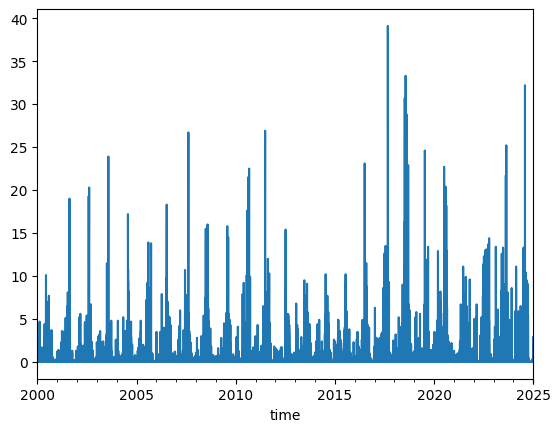

In [7]:
rain = df1['rain']
rain.plot()

## 2.4 For Multivariate: Converting TIme Stamp into usable signals

time stamp (using rain col):
1. day sin & day cos
2. year sin & year cos

In [8]:
rain_df = pd.DataFrame({'Rain': rain})
rain_df

,Rain
time,
2000-01-01 00:00:00,0.0
2000-01-01 01:00:00,0.0
2000-01-01 02:00:00,0.0
2000-01-01 03:00:00,0.0
2000-01-01 04:00:00,0.0
...,...
2025-01-01 19:00:00,0.0
2025-01-01 20:00:00,0.0
2025-01-01 21:00:00,0.0


In [9]:
rain_df[rain_df['Rain'] != 0]['Rain']

time
2000-01-09 04:00:00    0.1
2000-01-11 02:00:00    0.2
2000-01-11 03:00:00    0.3
2000-01-12 04:00:00    0.2
2000-01-12 05:00:00    0.6
                      ... 
2024-12-28 04:00:00    1.1
2024-12-28 05:00:00    1.3
2024-12-28 06:00:00    0.3
2024-12-28 10:00:00    0.1
2024-12-28 11:00:00    0.1
Name: Rain, Length: 35978, dtype: float64

In [10]:
rain_df['Seconds'] = rain_df.index.map(pd.Timestamp.timestamp)
rain_df

,Rain,Seconds
time,,
2000-01-01 00:00:00,0.0,9.466848e+08
2000-01-01 01:00:00,0.0,9.466884e+08
2000-01-01 02:00:00,0.0,9.466920e+08
2000-01-01 03:00:00,0.0,9.466956e+08
2000-01-01 04:00:00,0.0,9.466992e+08
...,...,...
2025-01-01 19:00:00,0.0,1.735758e+09
2025-01-01 20:00:00,0.0,1.735762e+09
2025-01-01 21:00:00,0.0,1.735765e+09


In [11]:
day = 24 * 60 * 60
year = (365.2425) * day

rain_df['Day sin'] = np.sin(rain_df['Seconds'] * (2 * np.pi / day))
rain_df['Day cos'] = np.cos(rain_df['Seconds'] * (2 * np.pi / day))
rain_df['Year sin'] = np.sin(rain_df['Seconds'] * (2 * np.pi / year))
rain_df['Year cos'] = np.cos(rain_df['Seconds'] * (2 * np.pi / year))
rain_df

,Rain,Seconds,Day sin,Day cos,Year sin,Year cos
time,,,,,,
2000-01-01 00:00:00,0.0,9.466848e+08,-5.461913e-12,1.000000,-0.004731,0.999989
2000-01-01 01:00:00,0.0,9.466884e+08,2.588190e-01,0.965926,-0.004014,0.999992
2000-01-01 02:00:00,0.0,9.466920e+08,5.000000e-01,0.866025,-0.003297,0.999995
2000-01-01 03:00:00,0.0,9.466956e+08,7.071068e-01,0.707107,-0.002580,0.999997
2000-01-01 04:00:00,0.0,9.466992e+08,8.660254e-01,0.500000,-0.001864,0.999998
...,...,...,...,...,...,...
2025-01-01 19:00:00,0.0,1.735758e+09,-9.659258e-01,0.258819,0.025013,0.999687
2025-01-01 20:00:00,0.0,1.735762e+09,-8.660254e-01,0.500000,0.025730,0.999669
2025-01-01 21:00:00,0.0,1.735765e+09,-7.071068e-01,0.707107,0.026446,0.999650


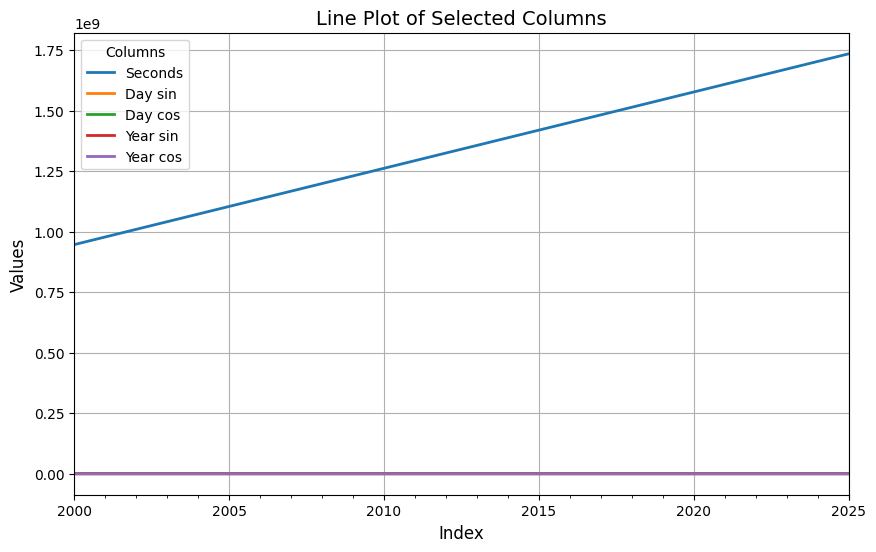

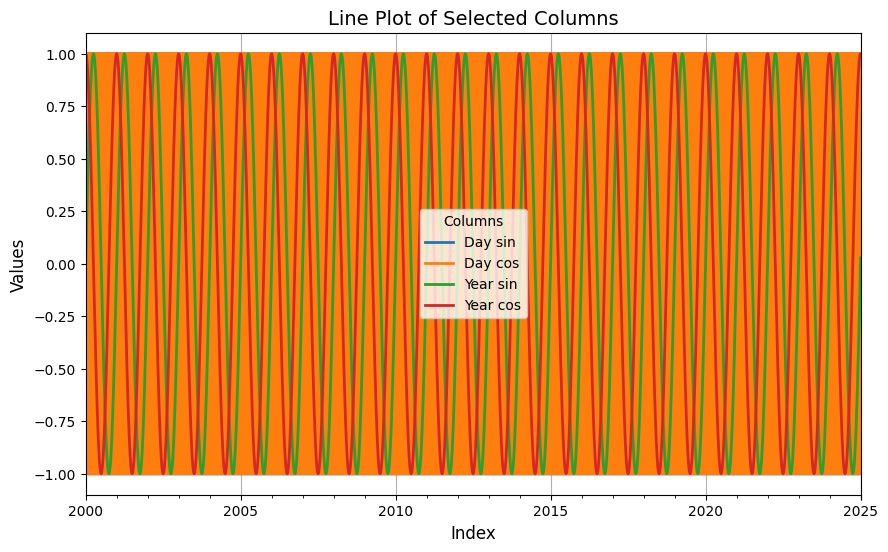

In [12]:
def plot_columns(df, columns_to_plot):
    """
    Plots specified columns of a DataFrame.

    Parameters:
    - df: pandas DataFrame
    - columns_to_plot: List of column names to plot
    """

    # Plot the data
    df[columns_to_plot].plot(
        figsize=(10, 6),
        linewidth=2
    )

    # Customize the plot
    plt.xlabel('Index', fontsize=12)
    plt.ylabel('Values', fontsize=12)
    plt.title(f'Line Plot of Selected Columns', fontsize=14)
    plt.legend(title='Columns', fontsize=10)
    plt.grid(True)
    plt.show()

plot_columns(rain_df, ['Seconds', 'Day sin', 'Day cos', 'Year sin', 'Year cos'])

plot_columns(rain_df, ['Day sin', 'Day cos', 'Year sin', 'Year cos'])

In [13]:
rain_df = rain_df.drop(['Seconds'], axis=1)
rain_df.columns

Index(['Rain', 'Day sin', 'Day cos', 'Year sin', 'Year cos'], dtype='object')

## 2.5 Batch Windowing

In [14]:
# [[[r1, ds1, dc1], [r2, ds2, dc2], [r3, ds3, dc3], [r4, ds4, dc4], [r5, ds5, dc5]]] = [r6]
# [[[r2, ds2], [r3, ds3], [r4, ds4], [r5, ds5], [r6, ds6]]] = [r7]
# [[[r3, ds3], [r4, ds4], [r5, ds5], [r6, ds6], [r7, ds7]]] = [r8]

def df_to_X_y(df, window_size=6):
    df_as_np = df.to_numpy()
    X = []
    y = []
    
    for i in range(len(df_as_np) - window_size):
        row = [r for r in df_as_np[i: i + window_size]]
        X.append(row)
        
        label = df_as_np[i + window_size][0]
        y.append(label)
    
    return np.array(X), np.array(y)

In [15]:
X1, y1 = df_to_X_y(rain_df)
X1.shape, y1.shape

((219186, 6, 5), (219186,))

## 2.6 Train Test Val Split

In [16]:
X_train1, y_train1 = X1[:200000], y1[:200000]
X_val1, y_val1 = X1[200000:210000], y1[200000:210000]
X_test1, y_test1 = X1[210000:], y1[210000:]

X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((200000, 6, 5), (200000,), (10000, 6, 5), (10000,), (9186, 6, 5), (9186,))

## 2.7 Standardization (Standard Normal Distribution)

In [17]:
rain_df.Rain.unique()

array([ 0. ,  0.1,  0.2,  0.3,  0.6,  0.4,  0.7,  0.5,  0.9,  1.1,  0.8,
        1.4,  1.3,  2. ,  2.3,  1. ,  1.2,  1.5,  3. ,  2.7,  1.6,  1.9,
        3.3,  4.7,  3.9,  3.4,  2.5,  2.2,  2.1,  1.7,  1.8,  4.4,  3.1,
        2.4,  4.2,  4.3,  6.5,  7.6,  8.6,  8.9,  7.7,  7.8, 10.1,  9.7,
        9.6,  8.7,  8.3,  7.3,  4.5,  3.5,  3.2,  2.6,  2.8,  6.4,  4.9,
        5.2,  6. ,  3.7,  3.6,  3.8,  2.9,  4.8,  6.7,  5.9,  7. ,  5.1,
        4.6,  5.4,  5.5,  4.1,  6.1,  8.1,  5. , 12.4, 15.9, 17.9, 19. ,
       18.7, 17.4, 14.1,  9.8,  6.9,  5.3,  5.6,  6.3,  9.2, 13.9, 19.3,
       16.7, 18.8, 18.6, 15.4, 10.9,  8.2, 12. , 15.6, 16.9, 20.3,  4. ,
       11.5, 11.4,  9.4,  8. , 15.8, 19.8, 22.8, 23.9, 23.5, 21.1, 12.5,
       10.7,  9. , 11.6, 14.5, 16.5, 17.2, 16.4, 15.2,  9.5,  7.9,  8.4,
        6.6,  7.1, 10.3, 10.8,  7.2, 11.2,  6.2,  6.8,  9.3, 11.9, 13.8,
       13.3, 13.2,  5.7, 15.7, 18.3,  5.8, 21. , 19.9, 21.4, 25.1, 26.7,
       22.9,  8.8,  7.4, 11. , 13.7, 15. , 15.5, 14

In [18]:
rain_training_mean = np.mean(X_train1[:, :, 0])
rain_training_std = np.std(X_train1[:, :, 0])

def preprocess_standardize(X):
    X[:, :, 0] = (X[:, :, 0] - rain_training_mean) / rain_training_std
    return X

In [19]:
preprocess_standardize(X_train1)
preprocess_standardize(X_val1)
preprocess_standardize(X_test1)

array([[[-1.98473682e-01, -9.94983602e-12,  1.00000000e+00,
         -2.73354562e-01,  9.61913345e-01],
        [-1.98473682e-01,  2.58819045e-01,  9.65925826e-01,
         -2.72665009e-01,  9.62109034e-01],
        [-1.98473682e-01,  5.00000000e-01,  8.66025404e-01,
         -2.71975317e-01,  9.62304228e-01],
        [-1.98473682e-01,  7.07106781e-01,  7.07106781e-01,
         -2.71285484e-01,  9.62498928e-01],
        [-1.98473682e-01,  8.66025404e-01,  5.00000000e-01,
         -2.70595512e-01,  9.62693133e-01],
        [-1.98473682e-01,  9.65925826e-01,  2.58819045e-01,
         -2.69905401e-01,  9.62886844e-01]],

       [[-1.98473682e-01,  2.58819045e-01,  9.65925826e-01,
         -2.72665009e-01,  9.62109034e-01],
        [-1.98473682e-01,  5.00000000e-01,  8.66025404e-01,
         -2.71975317e-01,  9.62304228e-01],
        [-1.98473682e-01,  7.07106781e-01,  7.07106781e-01,
         -2.71285484e-01,  9.62498928e-01],
        [-1.98473682e-01,  8.66025404e-01,  5.00000000e-01,
  

## 2.8 Combining 'df1' & 'rain_df'

In [20]:
df2 = pd.concat([df1, rain_df], axis=1)
df2 = df2.drop(['time','rain'], axis=1)
df2

,temperature_2m,relative_humidity_2m,dew_point_2m,cloud_cover_low,cloud_cover_mid,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_speed_100m,wind_gusts_10m,Rain,Day sin,Day cos,Year sin,Year cos
time,,,,,,,,,,,,,,,
2000-01-01 00:00:00,4.0,96,3.3,0,0,0.00,0.04,3.8,3.6,11.5,0.0,-5.461913e-12,1.000000,-0.004731,0.999989
2000-01-01 01:00:00,4.1,95,3.3,0,1,0.00,0.04,4.1,4.4,11.9,0.0,2.588190e-01,0.965926,-0.004014,0.999992
2000-01-01 02:00:00,4.0,95,3.2,0,1,0.01,0.04,3.8,4.5,11.9,0.0,5.000000e-01,0.866025,-0.003297,0.999995
2000-01-01 03:00:00,6.5,92,5.3,0,3,0.02,0.07,4.3,4.0,13.0,0.0,7.071068e-01,0.707107,-0.002580,0.999997
2000-01-01 04:00:00,12.9,75,8.6,0,0,0.13,0.37,2.0,2.5,13.0,0.0,8.660254e-01,0.500000,-0.001864,0.999998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-01 19:00:00,9.8,77,5.8,0,0,0.00,0.28,3.0,5.8,6.1,0.0,-9.659258e-01,0.258819,0.025013,0.999687
2025-01-01 20:00:00,10.6,67,4.7,0,0,0.00,0.43,2.8,6.2,6.1,0.0,-8.660254e-01,0.500000,0.025730,0.999669
2025-01-01 21:00:00,11.1,59,3.3,0,0,0.00,0.54,3.5,5.8,6.1,0.0,-7.071068e-01,0.707107,0.026446,0.999650


In [21]:
df2.columns

Index(['temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'cloud_cover_low', 'cloud_cover_mid', 'et0_fao_evapotranspiration',
       'vapour_pressure_deficit', 'wind_speed_10m', 'wind_speed_100m',
       'wind_gusts_10m', 'Rain', 'Day sin', 'Day cos', 'Year sin', 'Year cos'],
      dtype='object')

## 2.9 Batch Windowing for the whole df

In [22]:
remaining_columns_to_target = [
    'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'cloud_cover_low', 
    'cloud_cover_mid', 'et0_fao_evapotranspiration', 'vapour_pressure_deficit', 
    'wind_speed_10m', 'wind_speed_100m', 'wind_gusts_10m'
]

In [23]:
# [[[r1, ds1, dc1], [r2, ds2, dc2], [r3, ds3, dc3], [r4, ds4, dc4], [r5, ds5, dc5]]] = [r6]
# [[[r2, ds2], [r3, ds3], [r4, ds4], [r5, ds5], [r6, ds6]]] = [r7]
# [[[r3, ds3], [r4, ds4], [r5, ds5], [r6, ds6], [r7, ds7]]] = [r8]

X2, y2 = df_to_X_y(df2, window_size=16)
# X2, y2 = df_to_X_y(df2)
X2.shape, y2.shape

((219176, 16, 15), (219176,))

## 2.10 Train Test Val Split

In [24]:
df2.shape

(219192, 15)

In [25]:
def split_time_series_data(X, y, train_ratio=0.8, val_ratio=0.1):
    """
    Splits time series data into training, validation, and testing sets sequentially.

    Parameters:
    - X: Features (numpy array, DataFrame).
    - y: Labels (numpy array, Series).
    - train_ratio: Proportion of data for training (default 0.8).
    - val_ratio: Proportion of data for validation (default 0.1).

    Returns:
    - X_train, X_val, X_test, y_train, y_val, y_test: Sequentially split data.
    """
    # Calculate the number of samples for each split
    n = len(X)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)

    # Split data sequentially
    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [26]:
# 80% Training: First 800 samples.
# 10% Validation: Next 100 samples.
# 10% Testing: Final 100 samples.

X_train2, X_val2, X_test2, y_train2, y_val2, y_test2 = split_time_series_data(X2, y2)
X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

((175340, 16, 15),
 (175340,),
 (21917, 16, 15),
 (21917,),
 (21919, 16, 15),
 (21919,))

## 2.11 Standardization of i/p & o/p

In [27]:
rain_training_mean2 = np.mean(X_train2[:, :, 0])
rain_training_std2 = np.std(X_train2[:, :, 0])

def preprocess_standardize2(X):
    X[:, :, 0] = (X[:, :, 0] - rain_training_mean2) / rain_training_std2
    return X

def preprocess__standardize_output(y):
    # Check if y is 1D or 2D
    if len(y.shape) == 2:  # If it's 2D (like a column vector), you can index it
        y[:, 0] = (y[:, 0] - rain_training_mean2) / rain_training_std2
    else:  # If it's 1D, you don't need the extra index
        y = (y - rain_training_mean2) / rain_training_std2
    return y

In [28]:
preprocess_standardize2(X_train2)
preprocess_standardize2(X_val2)
preprocess_standardize2(X_test2)

array([[[ 3.58039963e-01,  9.40000000e+01,  2.21000000e+01, ...,
          9.65925826e-01, -1.39409656e-02, -9.99902820e-01],
        [ 4.51084904e-01,  9.30000000e+01,  2.26000000e+01, ...,
          8.66025404e-01, -1.46576747e-02, -9.99892571e-01],
        [ 7.43511863e-01,  8.40000000e+01,  2.32000000e+01, ...,
          7.07106781e-01, -1.53743763e-02, -9.99881807e-01],
        ...,
        [ 8.76433208e-01,  8.80000000e+01,  2.48000000e+01, ...,
         -8.66025404e-01, -2.32574910e-02, -9.99729508e-01],
        [ 7.96680401e-01,  8.80000000e+01,  2.42000000e+01, ...,
         -7.07106781e-01, -2.39740734e-02, -9.99712581e-01],
        [ 6.90343325e-01,  9.10000000e+01,  2.40000000e+01, ...,
         -5.00000000e-01, -2.46906436e-02, -9.99695140e-01]],

       [[ 4.51084904e-01,  9.30000000e+01,  2.26000000e+01, ...,
          8.66025404e-01, -1.46576747e-02, -9.99892571e-01],
        [ 7.43511863e-01,  8.40000000e+01,  2.32000000e+01, ...,
          7.07106781e-01, -1.53743763e

In [29]:
preprocess__standardize_output(y_train2)
preprocess__standardize_output(y_val2)
preprocess__standardize_output(y_test2)

array([ 0.69034333,  0.66375906,  0.65046692, ..., -1.23701618,
       -1.31676898, -1.50285887])

## 2.12 Scaling

In [30]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Reshape the 3D array to 2D (combine samples and timesteps)
num_samples, num_timesteps, num_features = X_train2.shape
X_train2_reshaped = X_train2.reshape(-1, num_features)

# Fit and transform the scaler on training data
X_train2_scaled = scaler.fit_transform(X_train2_reshaped)

# Reshape back to 3D
X_train2 = X_train2_scaled.reshape(num_samples, num_timesteps, num_features)

# Repeat for validation and test datasets
X_val2_reshaped = X_val2.reshape(-1, num_features)
X_val2_scaled = scaler.transform(X_val2_reshaped)
X_val2 = X_val2_scaled.reshape(X_val2.shape)

X_test2_reshaped = X_test2.reshape(-1, num_features)
X_test2_scaled = scaler.transform(X_test2_reshaped)
X_test2 = X_test2_scaled.reshape(X_test2.shape)

print("Scaling completed!")

Scaling completed!


In [31]:
X_train2

array([[[-2.18075772e+00,  1.23262577e+00, -1.49317552e+00, ...,
          1.41421932e+00, -6.69240001e-03,  1.41391230e+00],
        [-2.16746559e+00,  1.18665564e+00, -1.49317552e+00, ...,
          1.36603108e+00, -5.67865815e-03,  1.41391673e+00],
        [-2.18075772e+00,  1.18665564e+00, -1.50782219e+00, ...,
          1.22475030e+00, -4.66491338e-03,  1.41392043e+00],
        ...,
        [-9.18004948e-01,  3.74024434e-02, -7.90135373e-01, ...,
         -1.36602445e+00,  6.48632270e-03,  1.41391324e+00],
        [-1.10409483e+00,  3.59193339e-01, -7.75488703e-01, ...,
         -1.22474367e+00,  7.50006185e-03,  1.41390823e+00],
        [-1.31676898e+00,  6.35014107e-01, -8.48722052e-01, ...,
         -9.99998412e-01,  8.51379715e-03,  1.41390249e+00]],

       [[-2.16746559e+00,  1.18665564e+00, -1.49317552e+00, ...,
          1.36603108e+00, -5.67865815e-03,  1.41391673e+00],
        [-2.18075772e+00,  1.18665564e+00, -1.50782219e+00, ...,
          1.22475030e+00, -4.66491338e

# 3.0 Model

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

## 3.1 LSTM

In [33]:
model_lstm = Sequential([
    InputLayer((16, 15)),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(16, 'relu'),
    Dense(8, 'relu'),
    Dense(1, 'linear')
])

model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 16, 64)         │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,569 (131.13 KB)

 Trainable params: 33,569 (131.13 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
def train_model(model, checkpoint_path, X_train, y_train, X_val, y_val, epochs=2, learning_rate=0.0001):
    """
    Function to compile and train a model with specified parameters.
    
    Args:
    - model: The Keras model to be trained.
    - checkpoint_path: File path to save the best model during training.
    - X_train, y_train: Training data and labels.
    - X_val, y_val: Validation data and labels.
    - epochs: Number of epochs for training (default: 2).
    - learning_rate: Learning rate for the optimizer (default: 0.0001).
    
    Returns:
    - history: Training history object.
    """
    # Define the model checkpoint
    checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mean_squared_error',
        metrics=[
            'root_mean_squared_error',
            'accuracy'
        ]
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        callbacks=[checkpoint]
    )

    return history

In [35]:
history_lstm = train_model(
    model=model_lstm,
    checkpoint_path='../artifacts/models/multivariate/model_lstm.keras',
    X_train=X_train2,
    y_train=y_train2,
    X_val=X_val2,
    y_val=y_val2,
    epochs=10
)

Epoch 1/10
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 89s 15ms/step - accuracy: 1.4519e-04 - loss: 62.5917 - root_mean_squared_error: 7.0988 - val_accuracy: 0.0000e+00 - val_loss: 12.2053 - val_root_mean_squared_error: 3.4936
Epoch 2/10
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 84s 15ms/step - accuracy: 1.4707e-04 - loss: 2.6437 - root_mean_squared_error: 1.6238 - val_accuracy: 0.0000e+00 - val_loss: 16.4799 - val_root_mean_squared_error: 4.0595
Epoch 3/10
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 87s 16ms/step - accuracy: 1.0815e-04 - loss: 1.3820 - root_mean_squared_error: 1.1750 - val_accuracy: 0.0000e+00 - val_loss: 18.6821 - val_root_mean_squared_error: 4.3223
Epoch 4/10
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 84s 15ms/step - accuracy: 1.9984e-04 - loss: 0.9742 - root_mean_squared_error: 0.9863 - val_accuracy: 0.0000e+00 - val_loss: 18.4153 - val_root_mean_squared_error: 4.2913
Epoch 5/10
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 86s 16ms/step - accuracy: 1.8010e-04 - loss: 0.6880 - root_mean_squared_error: 0.8293 - val_accuracy: 0.0

In [36]:
model_lstm = load_model('../artifacts/models/multivariate/model_lstm.keras')

## 3.2 LSTM Plot: Pred v/s Actual

In [37]:
def plot_predictions(model, X_data, y_data, label, start=50, end=500, ylabel='Rainfall (mm)', title_suffix=''):
    """
    Plots predictions vs actual values for a given model and dataset.
    
    Args:
    - model: The trained model to use for predictions.
    - X_data: Input data for predictions.
    - y_data: Actual target values.
    - label: A string indicating the dataset (e.g., 'Train', 'Validation', 'Test').
    - start, end: Range of data points to visualize (default: 50 to 500).
    - ylabel: Label for the y-axis (default: 'Rainfall (mm)').
    - title_suffix: Additional suffix for the title (optional).
    
    Returns:
    - A DataFrame containing the predictions and actual values.
    """
    # Make predictions
    predictions = model.predict(X_data).flatten()

    # Create a DataFrame to store results
    results_df = pd.DataFrame(data={f'{label} Predictions': predictions, 'Actual Values': y_data})
    print(results_df)

    # Plot the predictions and actual values
    plt.figure(figsize=(10, 6))
    plt.plot(results_df[f'{label} Predictions'][start:end], label=f'{label} Predictions', color='blue', linestyle='-')
    plt.plot(results_df['Actual Values'][start:end], label='Actual Values', color='orange', linestyle='--')

    # Add labels and title
    plt.xlabel('Time Stamps', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(f'{label} Predictions vs Actual Values {title_suffix}', fontsize=14)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    return results_df

5480/5480 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step
        Train Predictions  Actual Values
0                8.405123            9.4
1                7.358442            8.4
2                6.427209            7.4
3                5.608121            6.7
4                5.056808            6.0
...                   ...            ...
175335          15.985698           18.0
175336          15.851021           18.0
175337          15.436840           17.7
175338          15.040410           16.5
175339          14.226776           15.2

[175340 rows x 2 columns]


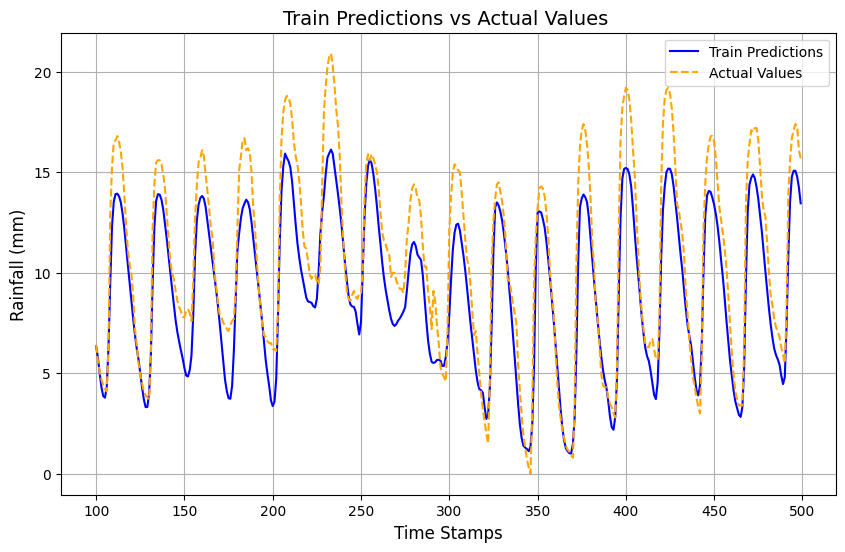

In [38]:
train_results = plot_predictions(
    model=model_lstm, 
    X_data=X_train2, 
    y_data=y_train2, 
    label='Train', 
    start=100, 
    end=500
)

685/685 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
       Val Predictions  Actual Values
0            13.037298           15.1
1            11.886194           11.1
2            10.667558           10.9
3             9.584914            9.4
4             8.543701            8.2
...                ...            ...
21912        24.581347           29.6
21913        24.273436           29.0
21914        23.895504           27.0
21915        22.893379           26.4
21916        22.287346           25.6

[21917 rows x 2 columns]


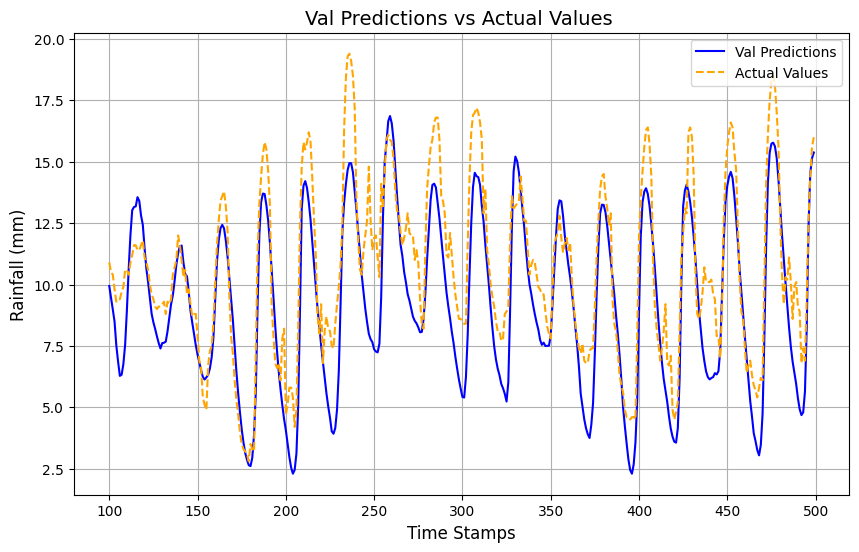

In [39]:
val_results = plot_predictions(
    model=model_lstm, 
    X_data=X_val2, 
    y_data=y_val2, 
    label='Val', 
    start=100, 
    end=500
)

685/685 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
       Test Predictions  Actual Values
0             21.704117           25.6
1             21.259424           25.4
2             20.848742           25.3
3             20.568836           24.6
4             20.375011           24.4
...                 ...            ...
21914          4.956219            9.8
21915          4.476420           10.6
21916          4.229891           11.1
21917          3.962070           10.5
21918          3.801586            9.1

[21919 rows x 2 columns]


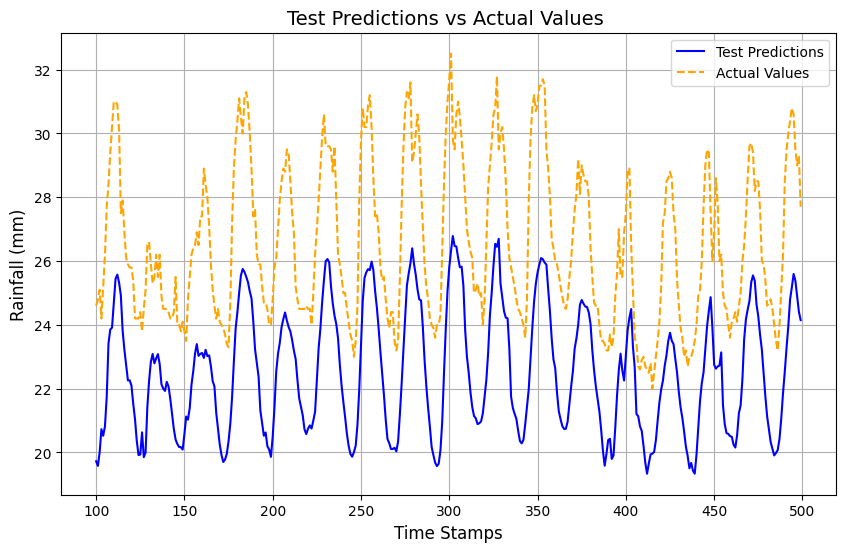

In [40]:
test_results = plot_predictions(
    model=model_lstm, 
    X_data=X_test2, 
    y_data=y_test2, 
    label='Test', 
    start=100, 
    end=500
)

## 3.3 GRU

In [41]:
model_gru = Sequential([
    InputLayer((16, 15)),
    GRU(64, activation='relu', return_sequences=True),
    GRU(32, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(16, 'relu'),
    Dense(8, 'relu'),
    Dense(1, 'linear')
])

model_gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 16, 64)         │        15,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,633 (100.13 KB)

 Trainable params: 25,633 (100.13 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
history_gru = train_model(
    model=model_gru,
    checkpoint_path='../artifacts/models/multivariate/model_gru.keras',
    X_train=X_train2,
    y_train=y_train2,
    X_val=X_val2,
    y_val=y_val2,
    epochs=10
)

Epoch 1/10
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 101s 17ms/step - accuracy: 1.5154e-04 - loss: 74.4903 - root_mean_squared_error: 7.7399 - val_accuracy: 0.0000e+00 - val_loss: 16.5340 - val_root_mean_squared_error: 4.0662
Epoch 2/10
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 96s 17ms/step - accuracy: 1.8853e-04 - loss: 1.6776 - root_mean_squared_error: 1.2938 - val_accuracy: 0.0000e+00 - val_loss: 18.4439 - val_root_mean_squared_error: 4.2946
Epoch 3/10
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 98s 18ms/step - accuracy: 1.3201e-04 - loss: 1.0010 - root_mean_squared_error: 0.9999 - val_accuracy: 0.0000e+00 - val_loss: 18.1027 - val_root_mean_squared_error: 4.2547
Epoch 4/10
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 97s 18ms/step - accuracy: 1.5617e-04 - loss: 0.7271 - root_mean_squared_error: 0.8523 - val_accuracy: 0.0000e+00 - val_loss: 16.9998 - val_root_mean_squared_error: 4.1231
Epoch 5/10
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 99s 18ms/step - accuracy: 2.4109e-04 - loss: 0.5922 - root_mean_squared_error: 0.7695 - val_accuracy: 0.

In [43]:
model_gru = load_model('../artifacts/models/multivariate/model_gru.keras')

## 3.4 GRU Plot: Pred v/s Actual

5480/5480 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step
        Train Predictions  Actual Values
0                8.468993            9.4
1                7.761549            8.4
2                7.024331            7.4
3                6.161540            6.7
4                5.316837            6.0
...                   ...            ...
175335          15.439455           18.0
175336          14.928411           18.0
175337          14.443394           17.7
175338          13.711451           16.5
175339          12.681304           15.2

[175340 rows x 2 columns]


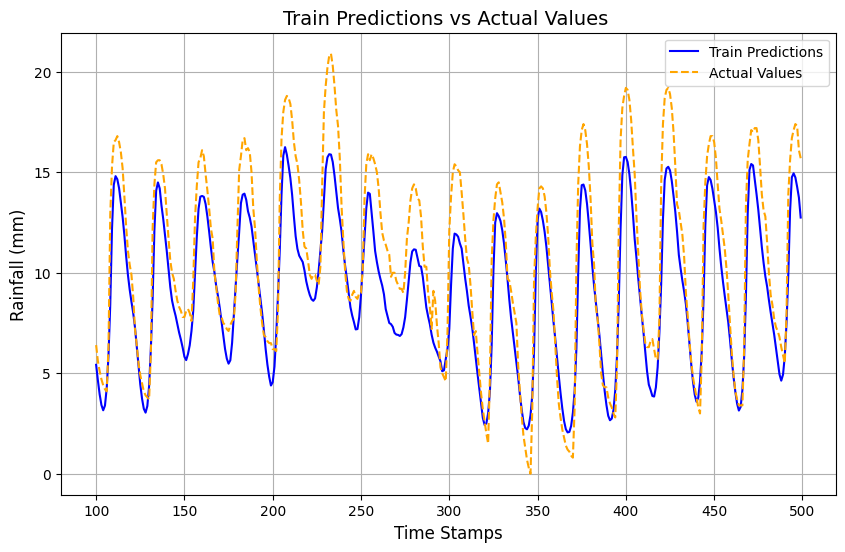

In [44]:
train_results = plot_predictions(
    model=model_gru, 
    X_data=X_train2, 
    y_data=y_train2, 
    label='Train', 
    start=100, 
    end=500
)

685/685 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
       Val Predictions  Actual Values
0            11.766665           15.1
1            11.081113           11.1
2             9.733212           10.9
3             8.858819            9.4
4             8.169434            8.2
...                ...            ...
21912        23.504980           29.6
21913        23.196985           29.0
21914        22.906260           27.0
21915        22.166487           26.4
21916        21.615915           25.6

[21917 rows x 2 columns]


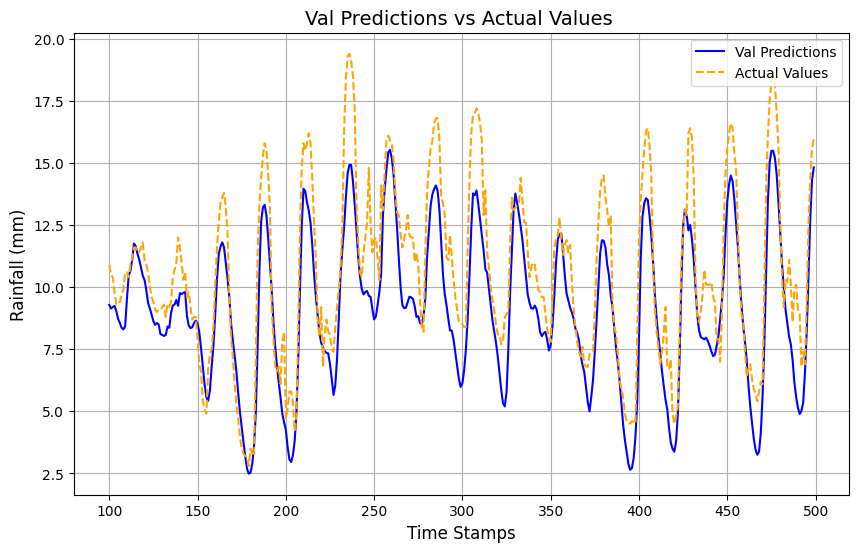

In [45]:
val_results = plot_predictions(
    model=model_gru, 
    X_data=X_val2, 
    y_data=y_val2, 
    label='Val', 
    start=100, 
    end=500
)

685/685 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
       Test Predictions  Actual Values
0             20.983393           25.6
1             20.600611           25.4
2             19.602993           25.3
3             19.462763           24.6
4             19.659735           24.4
...                 ...            ...
21914          5.562084            9.8
21915          5.230569           10.6
21916          5.106515           11.1
21917          5.073804           10.5
21918          5.155575            9.1

[21919 rows x 2 columns]


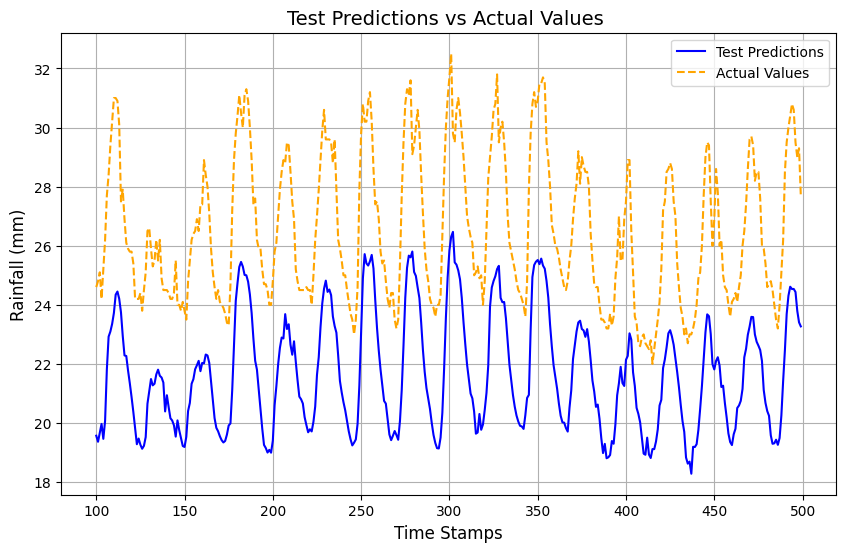

In [46]:
test_results = plot_predictions(
    model=model_gru, 
    X_data=X_test2, 
    y_data=y_test2, 
    label='Test', 
    start=100, 
    end=500
)

## 3.5 CNN 1D

In [47]:
model_cnn_1d = Sequential([
    InputLayer((16, 15)),
    Conv1D(64, kernel_size=2, activation='relu'),
    Conv1D(32, kernel_size=2, activation='relu'),
    GlobalAveragePooling1D(),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(8, 'relu'),
    Dense(1, 'linear')
])

model_cnn_1d.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 15, 64)         │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 14, 32)         │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,785 (26.50 KB)

 Trainable params: 6,785 (26.50 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
history_cnn_1d = train_model(
    model=model_cnn_1d,
    checkpoint_path='../artifacts/models/multivariate/model_cnn_1d.keras',
    X_train=X_train2,
    y_train=y_train2,
    X_val=X_val2,
    y_val=y_val2,
    epochs=10
)

Epoch 1/10
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 1.7045e-04 - loss: 135.3784 - root_mean_squared_error: 10.8859 - val_accuracy: 0.0000e+00 - val_loss: 5.1167 - val_root_mean_squared_error: 2.2620
Epoch 2/10
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 1.2472e-04 - loss: 7.8207 - root_mean_squared_error: 2.7939 - val_accuracy: 0.0000e+00 - val_loss: 10.0974 - val_root_mean_squared_error: 3.1776
Epoch 3/10
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 1.8590e-04 - loss: 4.4687 - root_mean_squared_error: 2.1133 - val_accuracy: 0.0000e+00 - val_loss: 16.2826 - val_root_mean_squared_error: 4.0352
Epoch 4/10
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 1.8904e-04 - loss: 3.4752 - root_mean_squared_error: 1.8640 - val_accuracy: 0.0000e+00 - val_loss: 17.1000 - val_root_mean_squared_error: 4.1352
Epoch 5/10
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 1.4617e-04 - loss: 3.0011 - root_mean_squared_error: 1.7323 - val_accuracy: 0.0000e

In [49]:
model_cnn_1d = load_model('../artifacts/models/multivariate/model_cnn_1d.keras')

## 3.6 CNN 1D Plot: Pred v/s Actual

5480/5480 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
        Train Predictions  Actual Values
0                9.298864            9.4
1                8.050516            8.4
2                6.921582            7.4
3                5.909568            6.7
4                5.096891            6.0
...                   ...            ...
175335          14.402040           18.0
175336          15.253139           18.0
175337          15.734407           17.7
175338          15.719442           16.5
175339          15.258260           15.2

[175340 rows x 2 columns]


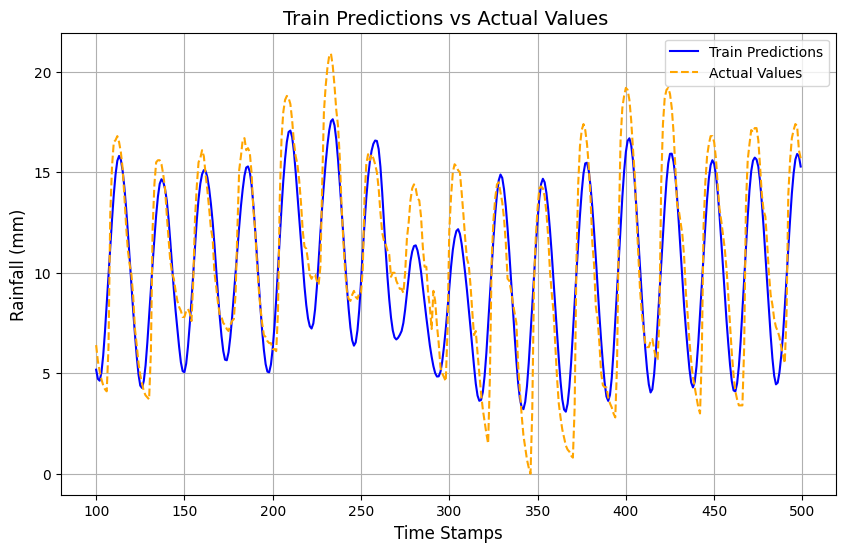

In [50]:
train_results = plot_predictions(
    model=model_cnn_1d, 
    X_data=X_train2, 
    y_data=y_train2, 
    label='Train', 
    start=100, 
    end=500
)

685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
       Val Predictions  Actual Values
0            14.492072           15.1
1            13.478866           11.1
2            12.248589           10.9
3            10.954730            9.4
4             9.637200            8.2
...                ...            ...
21912        27.264587           29.6
21913        26.635489           29.0
21914        26.090500           27.0
21915        25.792389           26.4
21916        25.674604           25.6

[21917 rows x 2 columns]


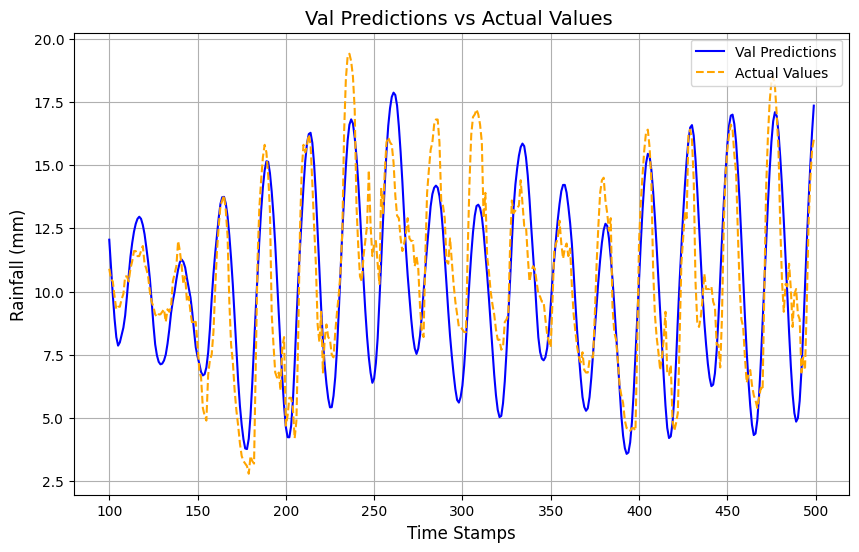

In [51]:
val_results = plot_predictions(
    model=model_cnn_1d, 
    X_data=X_val2, 
    y_data=y_val2, 
    label='Val', 
    start=100, 
    end=500
)

685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
       Test Predictions  Actual Values
0             25.199324           25.6
1             24.388397           25.4
2             23.637360           25.3
3             23.140690           24.6
4             22.885483           24.4
...                 ...            ...
21914          5.953535            9.8
21915          5.456122           10.6
21916          5.238810           11.1
21917          5.399766           10.5
21918          5.980641            9.1

[21919 rows x 2 columns]


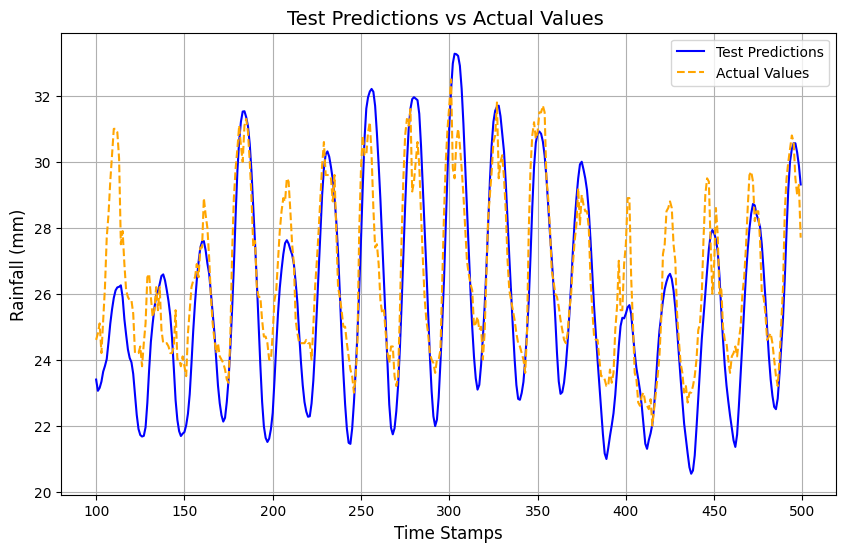

In [52]:
test_results = plot_predictions(
    model=model_cnn_1d, 
    X_data=X_test2, 
    y_data=y_test2, 
    label='Test', 
    start=100, 
    end=500
)